# Processamento de Imagem - SCC5830

## Aluno:
 - Victor Akihito Kamada Tomita | 10692082 | akihito012@usp.br | CCMC

obs: este notebook foi desenvolvido no google colab, por favor utilize o ambiente do colab para testar este notebook

---
# Análise de sentimentos em faces

---

Neste notebook será aplicado um fine tuning sobre a ResNet-50 para a análise de sentimentos em faces. Para tal, a ResNet será treinada sobre o FER-2013 em conjunto com um dataset colaborativo do github.

Este notebook permite gerar o modelo de análise de sentimentos em faces, que por sua vez será ser utilizado no notebook <code>Video Sentiment Analisys pipeline</code> para a extração de embeddings de faces.

---
### 1 . Identificação do Problema
---
Iremos utilizar a base de dados de análise de sentimentos do FER-2013, o qual é composto faces classificadas nas principais emoções. Para transforma-las em positivo, negativo ou neutro precisamos criar um filtro inicial.

---

In [ ]:
%%capture
!pip install --upgrade gdown
!gdown --id 15lONhfxOIXaqd7MrD5tU-xeVIN9DFKKY
!unzip FER2013.zip -d FER-13

In [ ]:
%%capture
!pip3 install ktrain

In [ ]:
%%capture
!git clone https://github.com/muxspace/facial_expressions.git

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ['DISABLE_V2_BEHAVIOR'] = '1' 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

In [ ]:
%%capture
from ktrain import vision as vis
import ktrain
import shutil
import csv
import os

In [ ]:
TEST_DIR = '/content/FER-13/test/'
TRAIN_DIR = '/content/FER-13/train/'

os.rename(TEST_DIR + 'angry', TEST_DIR + 'negative')
os.system('mv /content/FER-13/test/sad/* /content/FER-13/test/negative/ ')
os.rename(TEST_DIR + 'happy', TEST_DIR + 'positive')



In [ ]:
    year={2016},
    journal = {GitHub repository},
    howpublished = {\url{https://github.com/muxspace/facial_expressions.git}}


In [ ]:
os.rename(TRAIN_DIR + 'angry', TRAIN_DIR + 'negative')
os.system('mv /content/FER-13/train/sad/* /content/FER-13/train/negative/ ')
os.rename(TRAIN_DIR + 'happy', TRAIN_DIR + 'positive')

In [ ]:
not_used_sentiments = ['disgust', 'fear', 'sad', 'surprise']

for cur_sent in not_used_sentiments:
  shutil.rmtree(TEST_DIR + cur_sent)
  shutil.rmtree(TRAIN_DIR + cur_sent)



---
##2) Definição do pipeline de Pré-prcessamento/DataAugmentation
---

Para que possamos treinar um modelo mais robusto de análise de sentimentos aplico ténicas de data augmentation como flip horizontal, zoom, rotação ...

In [ ]:
DATADIR = 'FER-13'


data_augumentation = vis.get_data_aug(horizontal_flip=True, 
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      zoom_range=0.2)

(train_data, val_data, preproc) = vis.images_from_folder(datadir=DATADIR,
                                              # use a default data augmentation with horizontal_flip=True
                                              data_aug=data_augumentation, 
                                              train_test_names=['train', 'test'],
                                              target_size=(224,224))

color_mode detected (grayscale) different than color_mode selected (rgb)
Found 21005 images belonging to 3 classes.
Found 21005 images belonging to 3 classes.
Found 5212 images belonging to 3 classes.


---

Fazendo uma breve apresentação dos dados

---

sample images from each class:


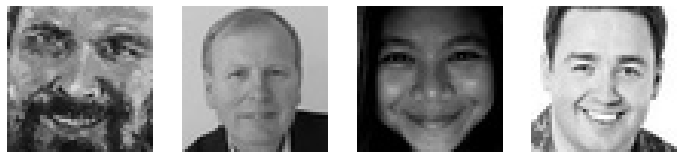

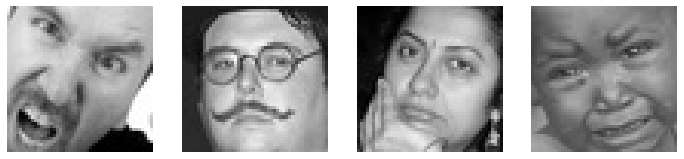

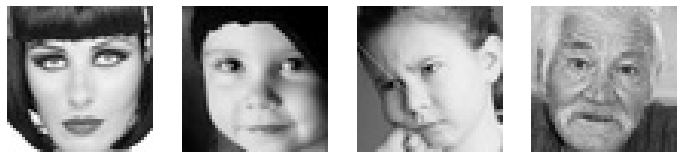

In [ ]:
DATADIR='FER-13'
print('sample images from each class:')
for cur_dir in os.listdir(DATADIR + '/test'):
  vis.show_random_images(DATADIR + '/test/' + cur_dir) 

---
## 3) Definição da arquitetura neural
---

Nesta etapa instanciamos a resnet50 pré-treinada para o problema da imagenet. A partir disso, congelamos as 30 camadas iniciais, tiramos a camada de final de 1000 neurônios. Por fim, adicionamos um dropout de 0.5, uma camada de 64 neurônios que servirá como embedding para a arquitetura multimodal e uma última camada de classificação

---

In [ ]:
model = vis.image_classifier('pretrained_resnet50', train_data, val_data, freeze_layers=30,  pt_fc=[64], pt_ps=[0.5])

The normalization scheme has been changed for use with a pretrained_resnet50 model. If you decide to use a different model, please reload your dataset with a ktrain.vision.data.images_from* function.

Is Multi-Label? False
Is Regression? False
94781440/94765736 [==============================] - 0s 0us/step
pretrained_resnet50 model created.


In [ ]:
learner = ktrain.get_learner(model=model, train_data=train_data, val_data=val_data, 
                             workers=8, use_multiprocessing=False, batch_size=128)

In [ ]:
learner.autofit(1e-4, 12)



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/12
165/165 [==============================] - ETA: 0s - batch: 82.0000 - size: 127.3030 - loss: 1.2179 - acc: 0.4535

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


165/165 [==============================] - 278s 1s/step - batch: 82.0000 - size: 127.3030 - loss: 1.2179 - acc: 0.4535 - val_loss: 0.9440 - val_acc: 0.5282
Epoch 2/12
165/165 [==============================] - 239s 1s/step - batch: 82.0000 - size: 127.3030 - loss: 0.9011 - acc: 0.5716 - val_loss: 0.8317 - val_acc: 0.6036
Epoch 3/12
165/165 [==============================] - 241s 1s/step - batch: 82.0000 - size: 127.3030 - loss: 0.8035 - acc: 0.6287 - val_loss: 0.7428 - val_acc: 0.6579
Epoch 4/12
165/165 [==============================] - 239s 1s/step - batch: 82.0000 - size: 127.3030 - loss: 0.7384 - acc: 0.6680 - val_loss: 0.7103 - val_acc: 0.6727
Epoch 5/12
165/165 [==============================] - 238s 1s/step - batch: 82.0000 - size: 127.3030 - loss: 0.7083 - acc: 0.6861 - val_loss: 0.6736 - val_acc: 0.7089
Epoch 6/12
165/165 [==============================] - 238s 1s/step - batch: 82.0000 - size: 127.3030 - loss: 0.6728 - acc: 0.7068 - val_loss: 0.6109 - val_acc: 0.7279
Epoch 7/1

In [ ]:
history = learner.history

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns


sns.set_theme()

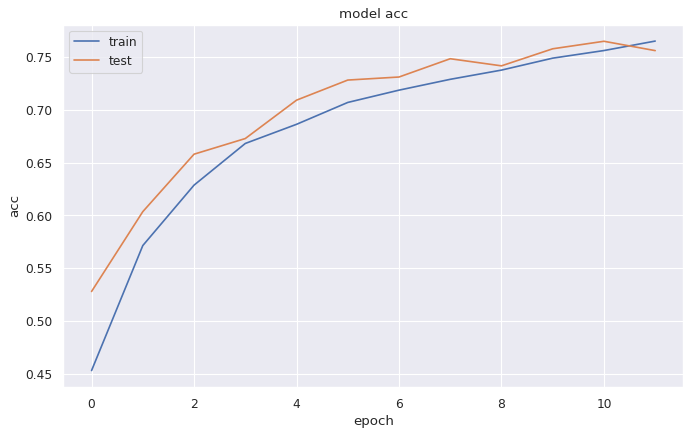

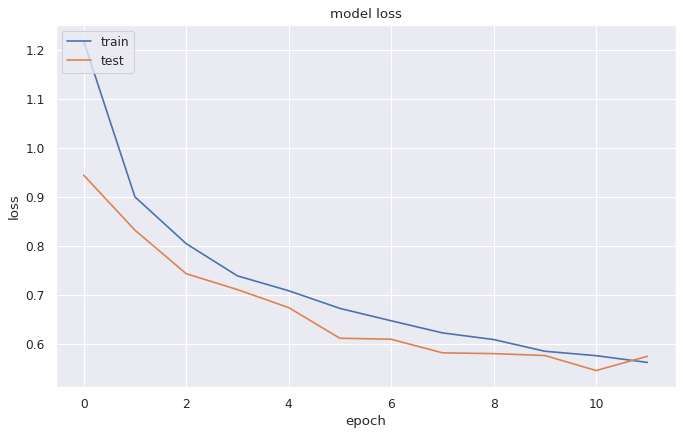

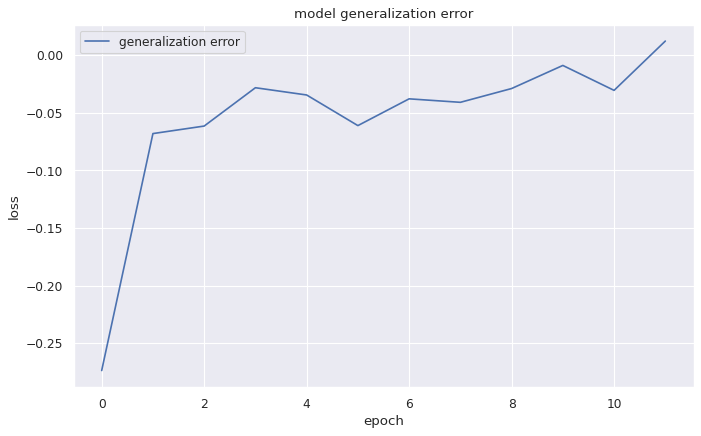

In [ ]:
figure(figsize=(10, 6), dpi=80)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
figure(figsize=(10, 6), dpi=80)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

figure(figsize=(10, 6), dpi=80)
plt.plot([i - j for i, j in zip(history.history['val_loss'], history.history['loss'] ) ])
plt.title('model generalization error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['generalization error'], loc='upper left')
plt.show()

In [ ]:
loss, acc = learner.model.evaluate_generator(learner.val_data, 
                                             steps=len(learner.val_data))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


In [ ]:
print('final loss:%s, final accuracy:%s' % (loss, acc))

final loss:0.5740170130974676, final accuracy:0.75575596


In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [ ]:
predictor.save('./sentiment_model_1')

In [ ]:
!zip -r sentiment_model_1.zip sentiment_model_1/

  adding: sentiment_model_1/ (stored 0%)
  adding: sentiment_model_1/tf_model.preproc (deflated 40%)
  adding: sentiment_model_1/tf_model.h5 (deflated 9%)


In [ ]:
from google.colab import files

files.download('sentiment_model_1.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>